<a href="https://colab.research.google.com/github/pierresegonne/COMP5328_Project2/blob/master/pierre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [0]:
# Install pytorch FOR GOOGLE COLAB
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 36.1MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 2.0MB/s 
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100


In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import umap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset

# UTILS

In [0]:
ROOT_DIRECTORY = '.'

In [3]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/COMP5328 Project2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def show_grid_images(images, title=''):
    """
    From a list of images,
    Plots all images along a kx5 grid.
    """
    nbr_images = images.shape[0]
    figsize_ref = 1
    rows, columns = int(nbr_images / 5), 5
    f = plt.figure(figsize=(figsize_ref*columns,figsize_ref*rows)) # 2 Columns, . Lines
    plt.axis('off')
    plt.title(title,  y=1.08) # Trick to offset the title.
    plt.subplots_adjust(wspace=-0.35, hspace=0)
    for index in range(nbr_images):
        image = images[index]
        ax = f.add_subplot(rows, columns, index + 1)
        ax.axis('off')
        ax.imshow(image, cmap=plt.cm.gray)
    
    plt.show()
    
def get_priors(Y):
    '''
    Estimation of priors for a set of labels
    '''
    priors = []
    classes = set(Y)
    masked = [i for i in Y]
    for c in classes:
        class_mask = (Y == c)
        priors.append(len(Y[class_mask]) / len(Y))
    return priors

def serialize_object(obj, file_name):
  with open(file_name, 'wb') as file_handler:
    pickle.dump(obj, file_handler, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickled(file_name):
  pickled_data = {}
  if os.path.getsize(file_name) > 0:      
    with open(file_name, "rb") as f:
      unpickler = pickle.Unpickler(f)
      pickled_data = unpickler.load()
  return pickled_data

# LOADING DATASETS

In [0]:
def load_dataset(dataset_name, path='{}/data/'.format(ROOT_DIRECTORY)):
    dataset = np.load(f'{path}{dataset_name}')
    X_train, Y_train = dataset['Xtr'], dataset['Str']
    X_test, Y_test = dataset['Xts'], dataset['Yts']
    
    return X_train, Y_train, X_test, Y_test

### ======================

In [140]:
MNIST_05_NAME = 'FashionMNIST0.5.npz'
MNIST_06_NAME = 'FashionMNIST0.6.npz'
CIFAR_NAME = 'CIFAR.npz'

mnist05_X_train, mnist05_Y_train, mnist05_X_test, mnist05_Y_test = load_dataset(MNIST_05_NAME)
print('Fashion MNIST 0.5 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist05_X_train.shape, mnist05_X_test.shape, set(mnist05_Y_train)))
mnist06_X_train, mnist06_Y_train, mnist06_X_test, mnist06_Y_test = load_dataset(MNIST_06_NAME)
print('Fashion MNIST 0.6 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist06_X_train.shape, mnist06_X_test.shape, set(mnist06_Y_train)))
cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test = load_dataset(CIFAR_NAME)
print('Fashion CIFAR dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(cifar_X_train.shape, cifar_X_test.shape, set(cifar_Y_train)))


Fashion MNIST 0.5 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion MNIST 0.6 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion CIFAR dataset, X_train shape: (15000, 32, 32, 3), X_test shape: (3000, 32, 32, 3), Classes in Y: {0, 1, 2}


In [141]:
# Transitions Matrices
mnist05_X_T = np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.5, 0.2],
    [0.2, 0.3, 0.5]
])

mnist06_X_T = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])

# Priors
mnist05_priors = get_priors(mnist05_Y_test)
mnist05_noisy_priors = get_priors(mnist05_Y_train)

mnist06_priors = get_priors(mnist06_Y_test)
mnist06_noisy_priors = get_priors(mnist06_Y_train)

cifar_priors = get_priors(cifar_Y_test)
cifar_noisy_priors = get_priors(cifar_Y_train)

print(f'Priors for MNIST 05, true labels: {mnist05_priors}, noisy labels: {mnist05_noisy_priors}')
print(f'Priors for MNIST 06, true labels: {mnist06_priors}, noisy labels: {mnist06_noisy_priors}')
print(f'Priors for CIFAR, true labels: {cifar_priors}, noisy labels: {cifar_noisy_priors}')

Priors for MNIST 05, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Priors for MNIST 06, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Priors for CIFAR, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## Image Visualization

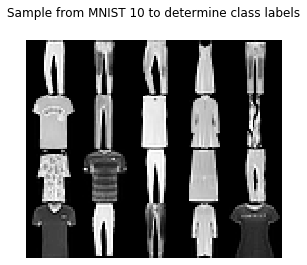

Associated Labels
[[1 1 1 2 1]
 [0 1 0 2 2]
 [2 0 1 2 1]
 [0 1 1 2 0]]


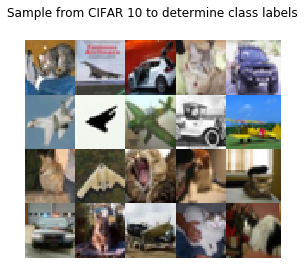

Associated Labels
[[2 0 1 2 1]
 [0 0 0 1 0]
 [2 0 2 2 2]
 [1 2 0 2 2]]


In [142]:
# Determine the association between class index and label from samples

nbr_examples = 20
show_grid_images(mnist05_X_test[:nbr_examples], 'Sample from MNIST 10 to determine class labels')
print('Associated Labels')
print(mnist05_Y_test[:nbr_examples].reshape(-1,5))

nbr_examples = 20
show_grid_images(cifar_X_test[:nbr_examples], 'Sample from CIFAR 10 to determine class labels')
print('Associated Labels')
print(cifar_Y_test[:nbr_examples].reshape(-1,5))

In [0]:
mnist_classes = ['t-shirt', 'trousers', 'dress']
cifar_classes = ['plane', 'car', 'cat']

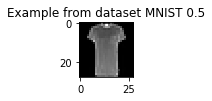

Associated Class: t-shirt


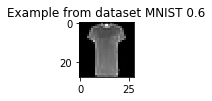

Associated Class: t-shirt


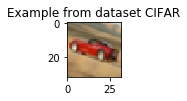

Associated Class: car


In [144]:
# From test to avoid label noise

# Fashion MNIST 0.5
plt.figure(figsize=(1,1))
plt.imshow(mnist05_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.5')
plt.show()
print(f'Associated Class: {mnist_classes[mnist05_Y_test[66]]}')


# Fashion MNIST 0.6
plt.figure(figsize=(1,1))
plt.imshow(mnist06_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.6')
plt.show()
print(f'Associated Class: {mnist_classes[mnist06_Y_test[66]]}')

# Fashion CIFAR
plt.figure(figsize=(1,1))
plt.imshow(cifar_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset CIFAR')
plt.show()
print(f'Associated Class: {cifar_classes[cifar_Y_test[66]]}')

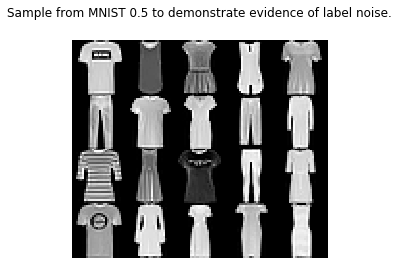

Associated Labels
[['dress' 'trousers' 'dress' 'trousers' 'dress']
 ['t-shirt' 'trousers' 't-shirt' 'trousers' 't-shirt']
 ['trousers' 'trousers' 'trousers' 'dress' 'dress']
 ['t-shirt' 'dress' 'dress' 'dress' 'dress']]


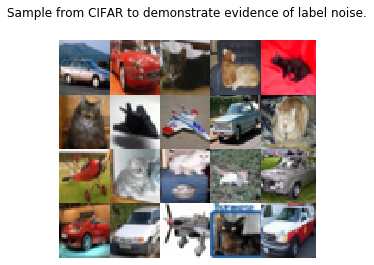

Associated Labels
[['car' 'cat' 'plane' 'cat' 'car']
 ['plane' 'plane' 'plane' 'car' 'plane']
 ['cat' 'cat' 'plane' 'plane' 'car']
 ['car' 'cat' 'plane' 'car' 'car']]


In [145]:
# Show evidence of label noise

nbr_examples = 20
show_grid_images(mnist05_X_train[:nbr_examples], 'Sample from MNIST 0.5 to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([mnist_classes[mnist05_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

show_grid_images(cifar_X_train[:nbr_examples], 'Sample from CIFAR to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([cifar_classes[cifar_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

# DATASET VISUALIZATION

In [0]:
# Resize datasets
# This transforms the datasets fron NxWxH to NxWH

# MNIST 0.5
mnist_image_size = [28, 28]
mnist05_X_train_2d = mnist05_X_train.reshape(-1, np.prod(mnist_image_size))
mnist05_X_test_2d = mnist05_X_test.reshape(-1, np.prod(mnist_image_size))

# MNIST 0.6
mnist06_X_train_2d = mnist06_X_train.reshape(-1, np.prod(mnist_image_size))
mnist06_X_test_2d = mnist06_X_test.reshape(-1, np.prod(mnist_image_size))

# CIFAR
cifar_image_size = [3, 32, 32]
cifar_X_train_2d = cifar_X_train.reshape(-1, np.prod(cifar_image_size))
cifar_X_test_2d = cifar_X_test.reshape(-1, np.prod(cifar_image_size))

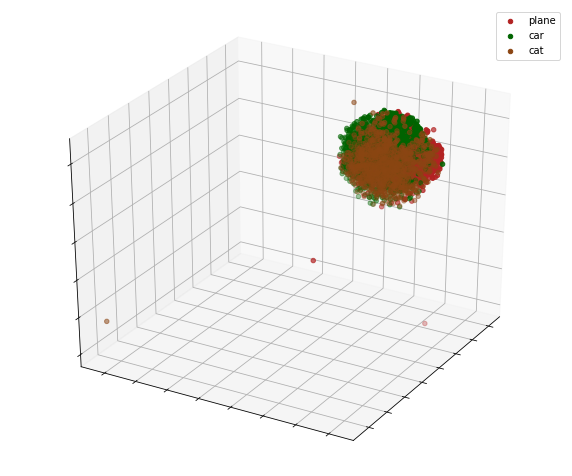

In [0]:
# t-SNE

def generate_tsne(dataset):
    tsne = TSNE(n_components=3, verbose=True, perplexity=40, n_iter=1000)
    return tsne.fit_transform(dataset['X'], dataset['Y'])

GENERATE_TSNE = False
DATASET = {'X': cifar_X_test_2d, 'Y': cifar_Y_test, 'labels': cifar_classes}

if GENERATE_TSNE:
    tsne_outputs = generate_tsne(DATASET)

class0_mask = (DATASET['Y'] == 0)
class1_mask = (DATASET['Y'] == 1)
class2_mask = (DATASET['Y'] == 2)

tsne_class0 = tsne_outputs[class0_mask]
tsne_class1 = tsne_outputs[class1_mask]
tsne_class2 = tsne_outputs[class2_mask]

fig = plt.figure(figsize=(10,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_class0[:,0], tsne_class0[:,1], tsne_class0[:,2], color='firebrick')
ax.scatter(tsne_class1[:,0], tsne_class1[:,1], tsne_class1[:,2], color='darkgreen')
ax.scatter(tsne_class2[:,0], tsne_class2[:,1], tsne_class2[:,2], color='saddlebrown')
ax.legend(DATASET['labels'])
ax.view_init(30, 30)
# ax.set_axis_off()
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
plt.show()

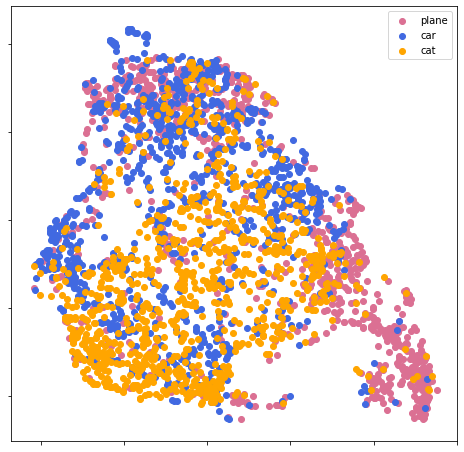

In [0]:
# UMAP

def generate_umap(dataset):

    return umap.UMAP(n_neighbors=5,
                      min_dist=0.1,
                      metric='correlation').fit_transform(dataset['X'])


GENERATE_UMAP = True
DATASET = {'X': cifar_X_test_2d, 'Y': cifar_Y_test, 'labels': cifar_classes}

if GENERATE_UMAP:
    umap_outputs = generate_umap(DATASET)

class0_mask = (DATASET['Y'] == 0)
class1_mask = (DATASET['Y'] == 1)
class2_mask = (DATASET['Y'] == 2)

umap_class0 = umap_outputs[class0_mask]
umap_class1 = umap_outputs[class1_mask]
umap_class2 = umap_outputs[class2_mask]

fig, ax = plt.subplots(1, figsize=(8,8))
ax.scatter(umap_class0[:,0], umap_class0[:,1], color='palevioletred')
ax.scatter(umap_class1[:,0], umap_class1[:,1], color='royalblue')
ax.scatter(umap_class2[:,0], umap_class2[:,1], color='orange')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(DATASET['labels'])
plt.show()

# ===========

# Label Noise Robust NN

In [44]:
# Utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The training will run on __ {} __'.format(device))

# Preprocessing
def grayscale_to_rgb(grayscale_dataset):
    """
    input dim: NxWxH
    output dim: NxWxHx3
    """
    return np.stack((grayscale_dataset,)*3, axis=-1)

def resize(X, image_size):
    """
    Resize a dataset of images (e.g go from 28x28 pixel images to 32x32)
    """
    resized_X = np.zeros((X.shape[0], image_size[0], image_size[1], X.shape[-1]))
    for i in range(X.shape[0]):
        resized_X[i, :, :, :] = cv2.resize(X[i, :, :, :], image_size, interpolation = cv2.INTER_AREA)
    return resized_X

def swap_channel_axis(X):
    """
    input dim: NxWxHx3
    output dim: Nx3xWxH
    """
    return np.swapaxes(X, -1, 1)

def normalize_per_channel(X):
    """
    Normalize a dataset per channel (e.g RBG channels)
    input dim: Nx3xWxH
    """
    means, stds = [], []
    for channel in range(X.shape[1]):
        mean, std = X[:, channel, :, :].mean(), X[:, channel, :, :].std()
        X[:, channel, :, :] = (X[:, channel, :, :] - mean) / std
        means.append(mean)
        stds.append(std)
    return X, {"mean": means, "std": stds}
        
def unnormalize(x, mean, std):
    x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
    return x

def showimg(tensor, normalization=None):
    """
    Show a tensor image, with possible normalization preprocessing.
    """
    npimg = tensor.numpy()
    if normalization:
        npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.figure(figsize=(15,10))
    plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
    plt.show()

def plot_grad_flow(named_parameters):
    """
    Util to verify the gradient flow in the network.
    """
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                print('Tensor with grad found:', tensor)
                print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])
    
class Evaluation(object):
    
    def __init__(self):
        self.loss = []
        self.accuracy = []

    
class Recordings():
    
    def __init__(self, progress_recording_frequency, evaluation_recording_frequency):
        self.progress = []
        self.evaluation = Evaluation()
        self.progress_recording_frequency = progress_recording_frequency
        self.evaluation_recording_frequency = evaluation_recording_frequency
    
    def log_progress(self, epoch, epochs, iteration, iterations):
        print(f'\n---- Epoch {epoch + 1}/{epochs}, Iteration {iteration + 1}/{iterations}')
        print('Loss : {:.4f}'.format(self.progress[-1]))

    def log_evaluation(self, epoch, epochs):
        print(f'\n----- Recording of Evaluation for epoch {epoch + 1}/{epochs}')
        print('Loss: {:.4f}, Accuracy: {:.4f}'.format(self.evaluation.loss[-1], self.evaluation.accuracy[-1]))
        
    def display(self):
        iterations_axes = [i * self.progress_recording_frequency for i in range(len(self.progress))]

        # Progress Loss
        fig, (ax1) = plt.subplots(1, 1, figsize=(9, 2))
        ax1.plot(iterations_axes, self.progress, color='darkslategray')
        fig.suptitle('Progress Loss')
        ax1.set(xlabel='Iterations', ylabel='Loss')
        plt.show()

        iterations_axes = [i * self.evaluation_recording_frequency for i in range(len(self.evaluation.loss))]

        # Evaluation Metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2))
        ax1.plot(iterations_axes, self.evaluation.loss, color='darkslategray')
        ax1.set(xlabel='Epochs', ylabel='Loss')
        ax2.plot(iterations_axes, self.evaluation.accuracy, color='darkslategray')
        ax2.set(xlabel='Epochs', ylabel='Accuracy')
        fig.suptitle('Evaluation Metrics Recording')
        plt.show()






The training will run on __ cuda __


In [0]:
# Data Loaders

# MNIST 05
mnist05_X_train_rgb = grayscale_to_rgb(mnist05_X_train)
mnist05_X_train_rgb = resize(mnist05_X_train_rgb, (32, 32))
mnist05_X_train_rgb = swap_channel_axis(mnist05_X_train_rgb)
mnist05_train_set = TensorDataset(torch.from_numpy(mnist05_X_train_rgb), torch.from_numpy(mnist05_Y_train))

mnist05_X_test_rgb = grayscale_to_rgb(mnist05_X_test)
mnist05_X_test_rgb = resize(mnist05_X_test_rgb, (32, 32))
mnist05_X_test_rgb = swap_channel_axis(mnist05_X_test_rgb)
mnist05_test_set = TensorDataset(torch.from_numpy(mnist05_X_test_rgb), torch.from_numpy(mnist05_Y_test))


# MNIST 06
mnist06_X_train_rgb = grayscale_to_rgb(mnist06_X_train)
mnist06_X_train_rgb = resize(mnist06_X_train_rgb, (32, 32))
mnist06_X_train_rgb = swap_channel_axis(mnist06_X_train_rgb)
mnist06_train_set = TensorDataset(torch.from_numpy(mnist06_X_train_rgb), torch.from_numpy(mnist06_Y_train))

mnist06_X_test_rgb = grayscale_to_rgb(mnist06_X_test)
mnist06_X_test_rgb = resize(mnist06_X_test_rgb, (32, 32))
mnist06_X_test_rgb = swap_channel_axis(mnist06_X_test_rgb)
mnist06_test_set = TensorDataset(torch.from_numpy(mnist06_X_test_rgb), torch.from_numpy(mnist06_Y_test))


# CIFAR
cifar_X_train = swap_channel_axis(cifar_X_train)
cifar_train_set = TensorDataset(torch.from_numpy(cifar_X_train), torch.from_numpy(cifar_Y_train))

cifar_X_test = swap_channel_axis(cifar_X_test)
cifar_test_set = TensorDataset(torch.from_numpy(cifar_X_test), torch.from_numpy(cifar_Y_test))

 ---- MNIST 05 Samples
dress t-shirt trousers dress t-shirt t-shirt trousers dress trousers t-shirt t-shirt trousers t-shirt trousers


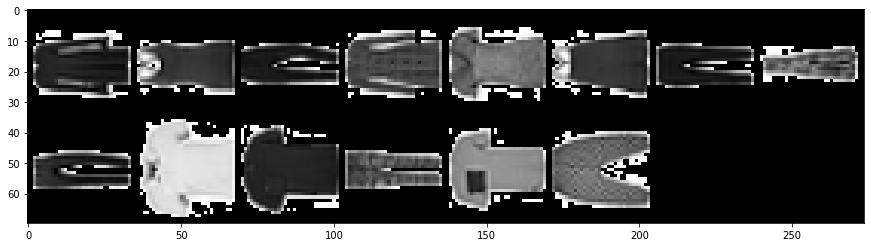

In [65]:
# Visualization test
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=14, shuffle=True)
dataiter = mnist05_test_loader.__iter__()
input, labels = dataiter.next()
print(' ---- MNIST 05 Samples')
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(input), normalization=None)

In [0]:
# Split training into training and validation
def get_training_validation_samplers(trainset, validation_proportion=0.1):
    indices = np.arange(len(trainset))
    np.random.shuffle(indices)
    split = int((1 - validation_proportion) * len(trainset))

    train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

    return train_sampler, validation_sampler

mnist05_train_sampler, mnist05_validation_sampler = get_training_validation_samplers(mnist05_train_set)
mnist06_train_sampler, mnist06_validation_sampler = get_training_validation_samplers(mnist06_train_set)
cifar_train_sampler, cifar_validation_sampler = get_training_validation_samplers(cifar_train_set)

In [48]:
# Model structure

class CNN(nn.Module):

    def __init__(self, number_classes=10):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # 5
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, number_classes),
        ) # No softmax because CrossEntropy loss does it.

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 5 * 5)
        x = self.classifier(x)
        return x
    
TEST_INPUT = True
if TEST_INPUT:
    cnn_test = CNN().to(device)
    INPUT_SIZE = (3, 32, 32)
    input_random = torch.rand((1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2])).to(device)
    print('Forward Test\n', cnn_test(input_random))

Forward Test
 tensor([[ 0.0154,  0.0277,  0.0282,  0.0245, -0.0110, -0.0248, -0.0236,  0.0023,
         -0.0179,  0.0051]], device='cuda:0', grad_fn=<AddmmBackward>)


In [0]:
# Training and Evaluation

def evaluate(model, loader, device, validation=False):
    # Eval flag
    model.eval()

    # Initialize metrics
    loss = 0.
    accuracy = 0.
    
    # Criterion
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for (inputs, labels) in loader:
            # To device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Prediction
            label_outputs = model(inputs.float())

            # Update loss
            loss += criterion(label_outputs, labels).data.item()

            # Update Accuracies
            predicted_labels = label_outputs.data.max(1)[1]
            accuracy += predicted_labels.eq(labels.data).sum().item()

    # Average metrics
    loss /= len(loader)
    if validation:        
        accuracy /= len(loader.sampler.indices)
    else:
        accuracy /= len(loader.dataset)

    return loss, accuracy


def train(model, optimizer, criterion, dataset, device, params, transition_matrix=None, verbose=True):
    if verbose:
        print('==== Start Training ====')
    # Train Flag
    model.train()
    
    # Recordings
    recordings = Recordings(params.log_progress_every, params.evaluate_model_every)

    # Number of classes
    nbr_classes = len(set(dataset.tensors[1].numpy()))

    # Type casting for inverse transition matrix
    if transition_matrix is not None:
        transition_matrix = transition_matrix.float()
    
    for epoch in range(params.epochs):

        # For shuffling, regenerate the dataloaders
        t_sampler, v_sampler = get_training_validation_samplers(dataset)
        t_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=t_sampler)
        v_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=v_sampler)
        
        for iteration, (inputs, labels) in enumerate(t_loader):
            # Prepare to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reset grad
            optimizer.zero_grad()

            # Outputs
            output_labels = model(inputs.float())

            # Loss
            if transition_matrix is not None:
                unique_labels = [c * torch.ones(labels.size()[0]).long().to(device) for c in range(nbr_classes)]
                losses = [criterion(output_labels, l) for l in unique_labels]
                losses = torch.stack(losses)
                corrected_losses = losses.transpose(0,1)@transition_matrix
                loss = corrected_losses.gather(1, labels.view(-1,1)).mean()
            else:
                loss = criterion(output_labels, labels).mean()

            # Optimize
            loss.backward()
            optimizer.step()
            
            # =======
            # Log Progress
            if ((iteration + 1) % params.log_progress_every == 0):
                recordings.progress.append(loss.data.item())
                if verbose:
                    recordings.log_progress(epoch, params.epochs, iteration, len(t_loader))
        
        # Evaluate
        if ((epoch + 1) % params.evaluate_model_every == 0):
            evaluation_loss, evaluation_accuracy = evaluate(model, v_loader, device, validation=True)
            recordings.evaluation.loss.append(evaluation_loss); recordings.evaluation.accuracy.append(evaluation_accuracy)

            if verbose:
                recordings.log_evaluation(epoch, params.epochs)

        # Save temporary model
        if ((epoch + 1) % params.save_model_every == 0):
            torch.save(model.state_dict(), params.model_filename)
    
    # Save final model
    torch.save(model.state_dict(), params.model_filename)

    # Save recordings
    serialize_object(recordings, params.recordings_filename)

    if verbose:
        print('==== End Training ====')
    
    return model, recordings
        
        
        
        

In [0]:
class Params(object):
    batch_size = 252
    epochs = 2
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 0
    
    log_progress_every = 50 # in iterations
    evaluate_model_every = 1 # in epochs

    save_model_every = 25 # in epochs
    model_filename = '{}/saves/model.pth'.format(ROOT_DIRECTORY)
    recordings_filename = '{}/saves/recordings.pickle'.format(ROOT_DIRECTORY)

params = Params()
model = CNN(number_classes=3).to(device).float()
optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
criterion = nn.CrossEntropyLoss(reduction='none')

# ====================================
# Loaders
mnist05_train_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_train_sampler)
mnist05_validation_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_validation_sampler)
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=params.batch_size, shuffle=False)

mnist06_train_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_train_sampler)
mnist06_validation_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_validation_sampler)
mnist06_test_loader = DataLoader(mnist06_test_set, batch_size=params.batch_size, shuffle=False)

cifar_train_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_train_sampler)
cifar_validation_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_validation_sampler)
cifar_test_loader = DataLoader(cifar_test_set, batch_size=params.batch_size, shuffle=False)

# ====================================
# Choose dataset and Transition Matrix
datasets_dict = {
    "mnist05": {
        "loaders": (mnist05_train_loader, mnist05_validation_loader, mnist05_test_loader),
        "dataset": mnist05_train_set,
        "testset": mnist05_test_set,
        "transition_matrix": torch.from_numpy(mnist05_X_T.T).to(device) # Transpose because defined differently than in lectures
        },
    "mnist06": {
        "loaders": (mnist06_train_loader, mnist06_validation_loader, mnist06_test_loader),
        "dataset": mnist06_train_set,
        "testset": mnist06_test_set,
        "transition_matrix": torch.from_numpy(mnist06_X_T.T).to(device) # Transpose because defined differently than in lectures
        },
    "cifar": {
        "loaders": (cifar_train_loader, cifar_validation_loader, cifar_test_loader),
        "dataset": cifar_train_set,
        "testset": cifar_test_set,
        "transition_matrix": torch.from_numpy(np.array(
            [[0.2796548,  0.37073188, 0.33353805],
            [0.37033914, 0.35247205, 0.28679701],
            [0.35000606, 0.27679607, 0.37966494]]
            ).T).to(device)
        },
}
# ==============
# Change dataset here
DATASET = 'cifar'
# Change whether to train the network for transition matrix estimation
ESTIMATION = True
# ==============


train_loader, validation_loader, test_loader = datasets_dict[DATASET]['loaders']
dataset = datasets_dict[DATASET]['dataset']
testset = datasets_dict[DATASET]['testset']
if not ESTIMATION:
    transition_matrix = datasets_dict[DATASET]['transition_matrix']
else:
    transition_matrix = None

## RUN

Code below are training runs, with different objectives

In [130]:
model, recordings = train(model, optimizer, criterion, dataset, device, params, transition_matrix=transition_matrix)

==== Start Training ====

---- Epoch 1/2, Iteration 50/54
Loss : 1.1002

----- Recording of Evaluation for epoch 1/2
Loss: 1.0991, Accuracy: 0.3293

---- Epoch 2/2, Iteration 50/54
Loss : 1.0981

----- Recording of Evaluation for epoch 2/2
Loss: 1.0985, Accuracy: 0.3513
==== End Training ====


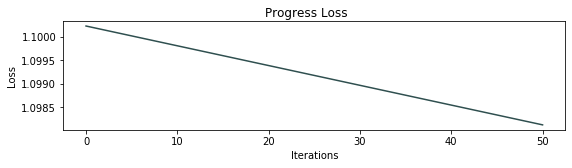

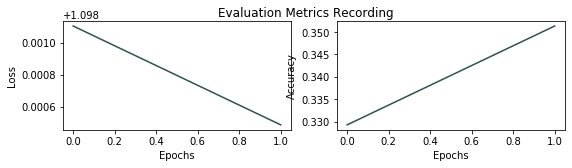

--- The loss over the test dataset is 1.0985115468502045 and the accuracy 0.3506666666666667


In [131]:
# Training Results and accuracy
recordings.display()

loss, accuracy = evaluate(model, test_loader, device)
print(f'--- The loss over the test dataset is {loss} and the accuracy {accuracy}')

------ Recordings display ------


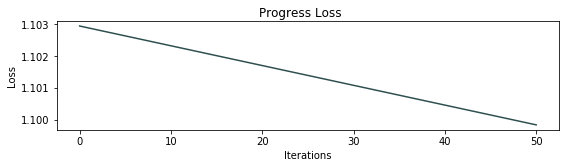

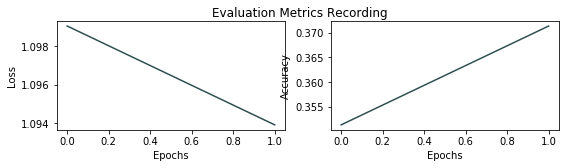

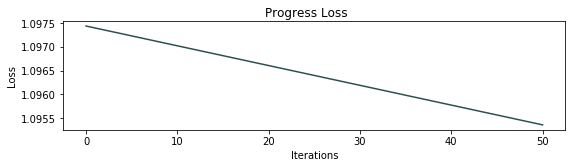

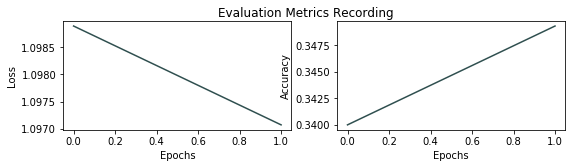

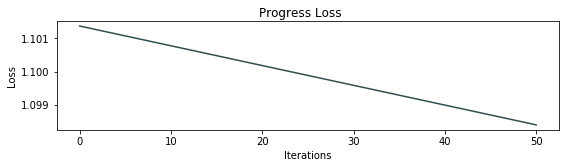

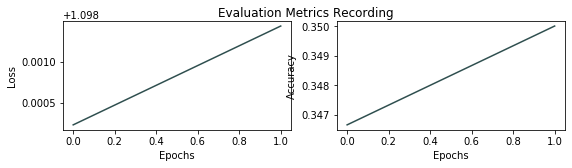

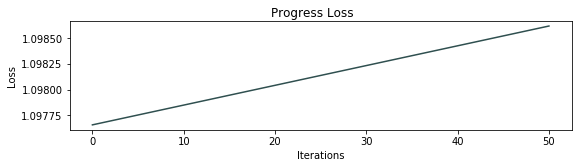

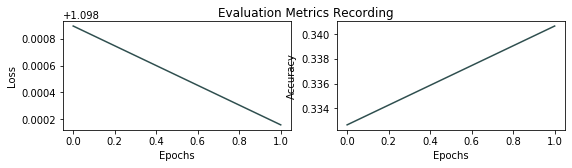

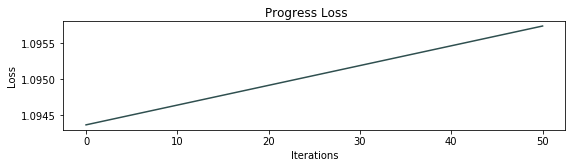

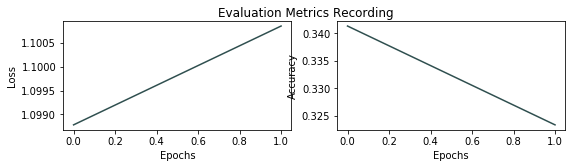

------ ------------------ ------
The losses: [1.0774891277154286, 1.092570165793101, 1.0701995491981506, 1.098673979441325, 1.1031700869401295]
The accuracies: [0.42933333333333334, 0.349, 0.5593333333333333, 0.33266666666666667, 0.336]


In [132]:
# Repetition for CV
N = 5

l, c, r = [], [], []
for n in range(N):
    model = CNN(number_classes=3).to(device).float()
    optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    model, recordings = train(model, optimizer, criterion, dataset, device, params, transition_matrix=transition_matrix, verbose=False)
    loss, accuracy = evaluate(model, test_loader, device)
    l.append(loss); c.append(accuracy); r.append(recordings)

print('------ Recordings display ------')
for rc in r:
    rc.display()
print('------ ------------------ ------')

print('The losses: {}\nThe accuracies: {}'.format(l,c))

## Estimation of the flip matrix

In [0]:
# Note that the transition matrix estimated is actually the transpose of the transition matrix defined in report.
def estimate_transition_matrix(trained_model, train_set, test_set, device):
    
    # First, find the anchor point xi
    nbr_classes = len(set(train_set.tensors[1].numpy()))
    nbr_train_samples = len((train_set.tensors[1].numpy()))

    x_i = []
    softmax = nn.Softmax(dim=1) # Softmax needed as it is not included in the architecture
    with torch.no_grad():
        trained_model.eval()
        all_outputs_train = trained_model(train_set.tensors[0].float().to(device)).cpu().numpy()
        all_outputs_test = trained_model(test_set.tensors[0].float().to(device)).cpu().numpy()

    # Merge train set and test set to get a bigger set to draw our samples from
    all_outputs = np.concatenate((all_outputs_train, all_outputs_test))
    x_i_indices = np.argmax(all_outputs, axis=0)

    estimated_transition_matrix = np.zeros((nbr_classes,nbr_classes))
    with torch.no_grad():
        trained_model.eval()
        for i, index in enumerate(x_i_indices):
            if index < nbr_train_samples:
                p_i = softmax(trained_model(train_set.tensors[0][index].float().to(device).view(1, 3, 32, 32)))
            else:
                test_index = index - nbr_train_samples
                p_i = softmax(trained_model(train_set.tensors[0][test_index].float().to(device).view(1, 3, 32, 32)))
            estimated_transition_matrix[i,:] = p_i.cpu().numpy()[0]

    return estimated_transition_matrix

In [134]:
# Generalization for estimation of the transtion matrix

N = 5
ESTIMATION = True
params.epochs = 7

nbr_classes = len(set(dataset.tensors[1].numpy()))
estimates = np.zeros((N, nbr_classes, nbr_classes))
for n in range(N):
    model = CNN(number_classes=nbr_classes).to(device).float()
    optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    trained_model, _ = train(model, optimizer, criterion, dataset, device, params, transition_matrix=transition_matrix, verbose=False)
    estimates[n,:,:] = estimate_transition_matrix(trained_model, dataset, testset, device)

print('========\nEstimated Transition Matrix:\n{}\n--------\nStandard Deviation:\n{}\n========'.format(
    np.mean(estimates, axis=0), np.std(estimates, axis=0)
    )
)

Estimated Transition Matrix:
[[0.46394185 0.28674091 0.24931726]
 [0.19867572 0.4787369  0.32258738]
 [0.18801129 0.33431298 0.47767575]]
--------
Standard Deviation:
[[0.06560794 0.03517428 0.04024925]
 [0.05190368 0.09191938 0.08659073]
 [0.05104258 0.05246342 0.03865454]]


========

## Upper Bound for accuracy

In [137]:
N = 5
params.epochs = 50
baseline_set = cifar_test_set

a = []
for n in range(N):
    # Define sets
    nbr_el = len(baseline_set.tensors[0])
    baseline_indices = [i for i in range(nbr_el)]
    np.random.shuffle(baseline_indices)
    split = int((1 - 0.1) * nbr_el)
    baseline_trainset_X = baseline_set.tensors[0].cpu().numpy()[baseline_indices[:split]]
    baseline_trainset_Y = baseline_set.tensors[1].cpu().numpy()[baseline_indices[:split]]
    baseline_testset_X = baseline_set.tensors[0].cpu().numpy()[baseline_indices[split:]]
    baseline_testset_Y = baseline_set.tensors[1].cpu().numpy()[baseline_indices[split:]]
    baseline_trainset = TensorDataset(torch.from_numpy(baseline_trainset_X), torch.from_numpy(baseline_trainset_Y))
    baseline_testset = TensorDataset(torch.from_numpy(baseline_testset_X), torch.from_numpy(baseline_testset_Y))
    baseline_testloader = DataLoader(baseline_testset, batch_size=params.batch_size, shuffle=False)

    # Train and evaluate
    model = CNN(number_classes=3).to(device).float()
    optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
    model, recordings = train(model, optimizer, criterion, baseline_trainset, device, params, transition_matrix=None, verbose=False)
    loss, accuracy = evaluate(model, baseline_testloader, device)
    a.append(accuracy)

print('The accuracies over the splits are {}'.format(a))

The accuracies over the splits are [0.7, 0.73, 0.7366666666666667, 0.64, 0.81]


# Visualization of outputs

 ---- MNIST 05 Samples
True      | dress |t-shirt |dress |t-shirt |trousers |trousers |t-shirt |t-shirt |trousers |t-shirt |t-shirt |trousers |dress |t-shirt
Predicted | dress |dress |t-shirt |t-shirt |t-shirt |trousers |t-shirt |t-shirt |t-shirt |trousers |t-shirt |trousers |trousers |t-shirt


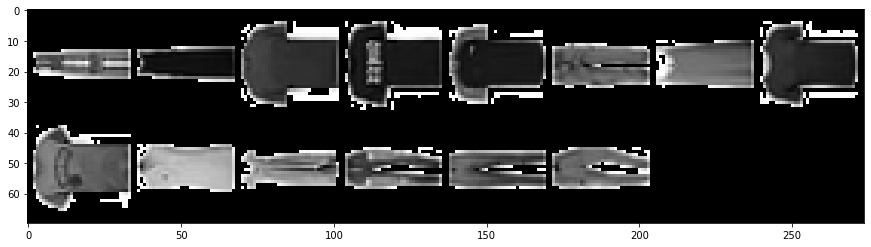

In [0]:
# Visualization test
visualization_loader = DataLoader(mnist05_train_set, batch_size=14, shuffle=True)
dataiter = visualization_loader.__iter__()
inputs, labels = dataiter.next()
with torch.no_grad():
    predicted_labels = model(inputs.to(device).float()).data.max(1)[1]
print(' ---- MNIST 05 Samples')
print('True      |', ' |'.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
print('Predicted |', ' |'.join('%5s' % mnist_classes[predicted_labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(inputs), normalization=None)

# *Experiments*

* **For MNIST 0.5** -> 2 epoch for T evaluation, 7 epochs for training

Benchmark accuracy on test dataset (crossvalidated) (30 epochs):  0.9933 (std 0.0037)

Benchmark accuracy on test dataset (crossvalidated) (7 epochs):  0.9612 (std 0.0139)

Accuracy Estimations:

| Epochs | No T | Given T | Estimated T |
| ------ | ---- | ------- | ----------- |
|   2    |   0.8627 (0.0440)   |   0.7263 (0.1993)      |             |
|   7    |   0.9313 (0.0049)   |   0.9140 (0.0123)      |             |
|   30   |   0.6211 (0.0315)   |   0.9029 (0.0146)      |             |


Estimated T:
```
========
Estimated Transition Matrix:
[[0.57169703 0.26156522 0.16673775]
 [0.1646015  0.55594877 0.27944973]
 [0.25698751 0.17812999 0.5648825 ]]
--------
Standard Deviation:
[[0.10981359 0.06610641 0.08243709]
 [0.07618615 0.12172385 0.0780935 ]
 [0.07004022 0.09109104 0.12588986]]
========
```

* **For MNIST 0.6** -> 2 epoch for T evaluation, 7 epochs for training

Benchmark accuracy on test dataset (crossvalidated) (30 epochs):  0.9933 (std 0.0037)

Benchmark accuracy on test dataset (crossvalidated) (7 epochs):  0.9612 (std 0.0139)

Accuracy Estimations:

| Epochs | No T | Given T | Estimated T |
| ------ | ---- | ------- | ----------- |
|   2    |   0.8418 (0.0315)   |   0.5733 (0.0976)      |             |
|   7    |   0.8777 (0.0099)   |   0.7749 (0.0295)      |             |
|   30   |   0.4817 (0.1024)   |   0.8084 (0.0153)      |             |

Even collapsed on a 30 epoch run (accuracy of 33% = random)

Estimated T:
```
Estimated Transition Matrix:
[[0.41694492 0.28186968 0.30118542]
 [0.2879194  0.41322886 0.29885175]
 [0.29090959 0.28788334 0.42120707]]
--------
Standard Deviation:
[[0.06567349 0.04518433 0.03398131]
 [0.02753232 0.03664427 0.0323216 ]
 [0.04675142 0.04586606 0.06102489]]
========
```

* **For CIFAR** -> 2 epoch for T evaluation, 7 epochs for training

Benchmark accuracy on test dataset (crossvalidated) (30 epochs):  0.9725 (std 0.0244)

Benchmark accuracy on test dataset (crossvalidated) (7 epochs):  0.5290 (std 0.0495)

Accuracy Estimations:

| Epochs | No T | Given T | Estimated T (P) | Estimated T (T) |
| ------ | ---- | ------- | ----------- | ----------- |
|   2    |   0.3854 (0.0606)   |   x      |     0.3772 (0.0259)        | 0.3377 (0.0421) |
|   7    |   0.4702 (0.0751)   |   x      |     0.3759 (0.0335)        | 0.3280 (0.0376) |
|   30   |   0.3807 (0.0040)   |   x      |     0.4087 (0.0754)        | 0.3369 (0.0237) |

Estimated T:

```
========
Estimated Transition Matrix:
[[0.36601161 0.32905289 0.3049355 ]
 [0.27715348 0.41431034 0.30853618]
 [0.28299314 0.32606457 0.39094229]]
--------
Standard Deviation:
[[0.0370664  0.03453427 0.04785429]
 [0.07818368 0.08336953 0.06365818]
 [0.05736126 0.04720174 0.06252377]]
========
```